# Assignment 5 –  Image Compression using SVD

**Image Used:** `barbara_gray.jpg` (512×512 grayscale)


Image shape: (512, 512)


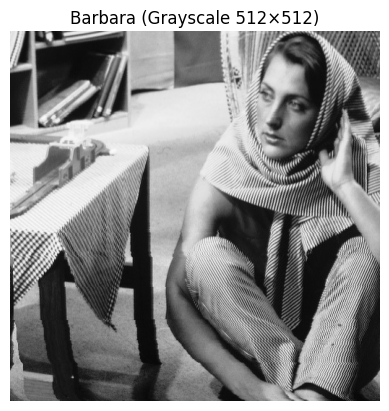

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
image = io.imread('barbara_gray.jpg') / 255.0  # Normalize to [0,1]

# Confirm image is grayscale and 512x512
print("Image shape:", image.shape)
plt.imshow(image, cmap='gray')
plt.title("Barbara (Grayscale 512×512)")
plt.axis('off')
plt.show()


## 1. Preprocessing

We use a 512×512 grayscale image named `barbara_gray.jpg`.  
This image does not require resizing or cropping, as it is already divisible by 8 in both dimensions.


In [2]:
def compress_block(block, k):
    U, S, VT = np.linalg.svd(block, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    VT_k = VT[:k, :]
    return U_k @ S_k @ VT_k

def compress_image(img, k):
    h, w = img.shape
    compressed = np.zeros_like(img)
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img[i:i+8, j:j+8]
            compressed[i:i+8, j:j+8] = compress_block(block, k)
    return compressed


## 2. Block-wise SVD Function

We define two functions to perform localized image compression using Singular Value Decomposition (SVD):

- `compress_block(block, k)`:  
  Applies SVD to a single 8×8 block and reconstructs it using only the top-𝑘 singular values. This retains the most significant features while reducing storage.

- `compress_image(img, k)`:  
  Divides the full image into non-overlapping 8×8 blocks, applies `compress_block()` to each, and stitches the results back together into a compressed image.

This block-wise approach allows us to compress different image regions independently and analyze how `k` affects the trade-off between compression and quality.


In [6]:
compression_ratios = []
errors = []
psnrs = []
images = []

for k in range(1, 9):
    comp = compress_image(image, k)
    images.append(comp)

    ratio = 64 / (17 * k)  # 64 values in original block, 17k in compressed
    compression_ratios.append(ratio)

    error = np.linalg.norm(image - comp, ord='fro')
    errors.append(error)

    mse = np.mean((image - comp) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse != 0 else float('inf')
    psnrs.append(psnr)
print("Compression Ratios:", compression_ratios)
print("Frobenius Errors:", errors)
print("PSNRs:", psnrs)



Compression Ratios: [3.764705882352941, 1.8823529411764706, 1.2549019607843137, 0.9411764705882353, 0.7529411764705882, 0.6274509803921569, 0.5378151260504201, 0.47058823529411764]
Frobenius Errors: [np.float64(40.739466319345965), np.float64(23.88222272314041), np.float64(8.813073433816626), np.float64(4.95322440786032), np.float64(2.5458953544682217), np.float64(1.1867627901805775), np.float64(0.36923034782258457), np.float64(8.425946429721571e-13)]
PSNRs: [np.float64(21.98509250928783), np.float64(26.623904335301148), np.float64(35.28285144269893), np.float64(40.28763913316575), np.float64(46.06858824739022), np.float64(52.69812080016597), np.float64(62.839451431473265), np.float64(295.67302534646353)]


## 3. Compression Analysis

For each value of `k` from 1 to 8, we apply the block-wise SVD compression to the image.

We compute the following metrics:

- **Compression Ratio**  
  Formula:  
  $$
  \text{Compression Ratio} = \frac{64}{17 \times k}
  $$

- **Reconstruction Error (Frobenius Norm)**  
  Measures how different the compressed image is from the original:  
  $$
  \|A - A_k\|_F
  $$

- **Peak Signal-to-Noise Ratio (PSNR)**  
  A standard image quality metric derived from MSE:  
  $$
  \text{PSNR} = 20 \cdot \log_{10} \left( \frac{1.0}{\sqrt{\text{MSE}}} \right)
  $$

These metrics help us quantify how much quality is lost as we reduce the number of singular values `k`.


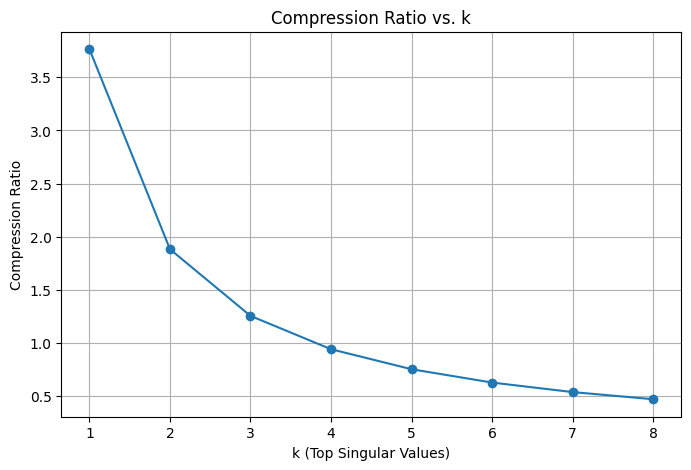

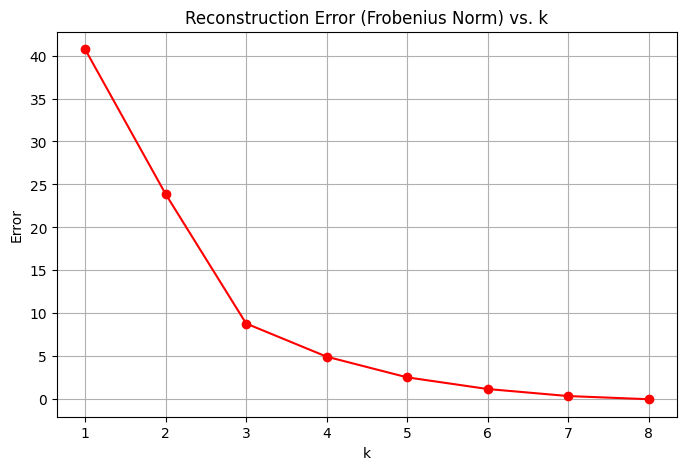

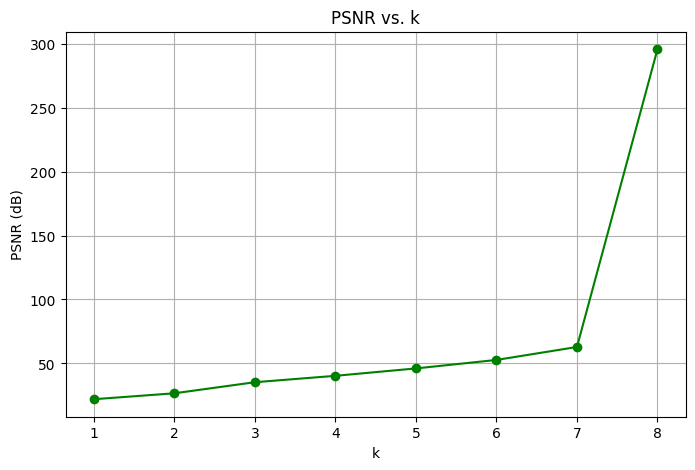

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), compression_ratios, marker='o')
plt.title("Compression Ratio vs. k")
plt.xlabel("k (Top Singular Values)")
plt.ylabel("Compression Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), errors, marker='o', color='red')
plt.title("Reconstruction Error (Frobenius Norm) vs. k")
plt.xlabel("k")
plt.ylabel("Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), psnrs, marker='o', color='green')
plt.title("PSNR vs. k")
plt.xlabel("k")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.show()


## 4. Visualization of Compression Metrics

To evaluate the effectiveness of the SVD-based image compression, we plotted three key metrics across values of `k` from 1 to 8:



### Compression Ratio vs. k

This plot shows how the compression ratio decreases as `k` increases.  
Since more singular values are retained at higher `k`, each block stores more data, reducing the overall compression.

- **Observation**: The drop is steep initially, especially from `k = 1` to `k = 3`, then begins to flatten.



### Reconstruction Error (Frobenius Norm) vs. k

This measures the difference between the original and reconstructed image.  
Lower error indicates better reconstruction.

- **Observation**: The error drops sharply from `k = 1` to `k = 5`, showing rapid quality recovery with just a few singular values.



### PSNR vs. k

PSNR (Peak Signal-to-Noise Ratio) quantifies image quality based on pixel-wise differences.  
Higher PSNR indicates better fidelity.

- **Observation**: PSNR increases gradually, then spikes at `k = 8` (perfect or near-perfect reconstruction).



These plots confirm that even small values of `k` (e.g., 4 or 5) provide a strong trade-off between compression and visual quality.


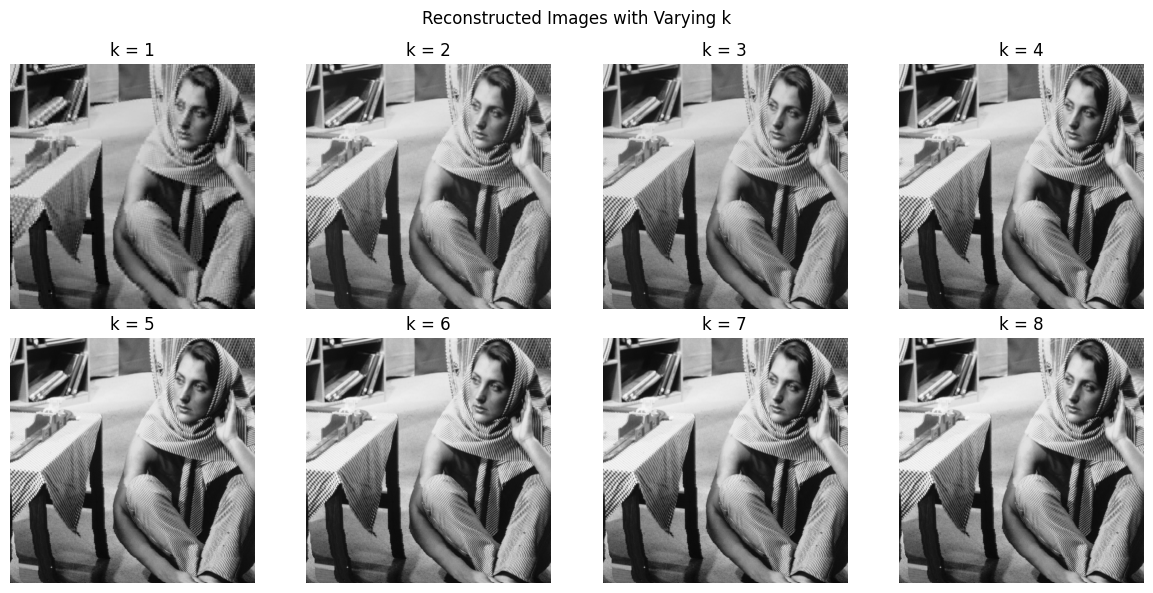

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'k = {i+1}')
    ax.axis('off')
plt.suptitle("Reconstructed Images with Varying k")
plt.tight_layout()
plt.show()


## 5. Reconstructed Images (Visual Comparison)

Below is a grid of reconstructed images for values of `k` ranging from 1 to 8.  
Each image was reconstructed by applying block-wise SVD and retaining only the top-𝑘 singular values per 8×8 block.



###  Observations:

- **k = 1 to 3**:  
  Images appear noticeably blurry. Only the most dominant features are retained, and fine details are lost.

- **k = 4 to 5**:  
  Significant improvement in clarity. Most of the visual information is recovered, while maintaining a good compression ratio.

- **k = 6 to 8**:  
  The image becomes sharper and visually very close to the original. At `k = 8`, the reconstruction is nearly perfect.



This visual comparison reinforces the trade-off observed in the plots:  
A small number of singular values (𝑘 ≈ 4–5) can preserve much of the image's structure, demonstrating the effectiveness of SVD for image compression.
